## Imports

In [1]:
import jax
import optax
import flax.linen as nn
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from flax.training import train_state

## Transformer Block

In [2]:
class TransformerBlock(nn.Module):
  d_model: int
  heads: int
  diff: int
  dropout_rate: float = 0.1

  @nn.compact
  def __call__(self, x, training = False):
    attn_out = nn.MultiHeadDotProductAttention(
        num_heads = self.heads,
        dtype=jnp.float32
    )(x, x)
    attn_out = nn.LayerNorm()(x + attn_out)

    ff_out = nn.Sequential([
        nn.Dense(self.diff, dtype=jnp.float32),
        nn.relu,
        # nn.Dropout(self.dropout_rate),
        nn.Dense(self.d_model, dtype = jnp.float32)
    ])(attn_out)
    return nn.LayerNorm()(attn_out + ff_out)


## Random Number Transformer

In [3]:
class RandomNumberTransformer(nn.Module):
  d_model: int
  heads: int
  diff: int
  num_layers: int
  vocab_size: int
  max_len: int

  @nn.compact
  def __call__(self, x, training = False):
    x = nn.Embed(self.vocab_size, self.d_model)(x)
    pos = jnp.arange(0, x.shape[1], dtype = jnp.float32)[:, jnp.newaxis]
    div_term = jnp.exp(jnp.arange(0, self.d_model, 2) * -(jnp.log(10000) / self.d_model))
    pe = jnp.zeros((x.shape[1], self.d_model))
    pe = pe.at[:, 0::2].set(jnp.sin(pos * div_term))
    pe = pe.at[:, 1::2].set(jnp.cos(pos * div_term))
    x += pe[jnp.newaxis, :, :]

    for _ in range(self.num_layers):
      x = TransformerBlock(
          d_model = self.d_model,
          heads = self.heads,
          diff = self.diff,
          dropout_rate = 0.1
      )(x, training = training)
    return nn.Dense(self.vocab_size)(x)


## Training Utilities

In [4]:
def create_train_state(rng, model, input_shape):
  @jax.jit
  def initialize_model(rng):
    return model.init(rng, jnp.ones(input_shape, dtype=jnp.int32))["params"]

  params = initialize_model(rng)
  tx = optax.adam(learning_rate = 1e-3)

  return train_state.TrainState.create(
      apply_fn = model.apply,
      params = params,
      tx = tx
  )

## Loss and Update Step

In [5]:
def cross_entropy_loss(logits, labels):
  one_hot_labels = jax.nn.one_hot(labels, logits.shape[-1])
  return jnp.mean(-jnp.sum(one_hot_labels * jax.nn.log_softmax(logits), axis=-1))

@jax.jit
def train_step(state, batch):
  def loss_fn(params):
    logits = state.apply_fn({"params": params}, batch, training = True)
    loss = cross_entropy_loss(logits[:, :-1, :], batch[:, 1:])
    return loss

  grad_fn = jax.value_and_grad(loss_fn)
  loss, grads = grad_fn(state.params)
  return state.apply_gradients(grads = grads), loss

def generate_random_number_sequence(num_sequences, max_len, vocab_size):
  return np.random.randint(0, vocab_size, size = (num_sequences, max_len))


## Train and Generate

Epoch: 0 | Loss: 5.085633754730225
Epoch: 10 | Loss: 4.626141548156738
Epoch: 20 | Loss: 4.620388031005859
Epoch: 30 | Loss: 4.620377540588379
Epoch: 40 | Loss: 4.627483367919922
Epoch: 50 | Loss: 4.619194507598877
Epoch: 60 | Loss: 4.611101150512695
Epoch: 70 | Loss: 4.612168312072754
Epoch: 80 | Loss: 4.612643718719482
Epoch: 90 | Loss: 4.615538120269775
Epoch: 100 | Loss: 4.6171698570251465
Epoch: 110 | Loss: 4.613712310791016
Epoch: 120 | Loss: 4.613996505737305
Epoch: 130 | Loss: 4.611415863037109
Epoch: 140 | Loss: 4.612955093383789
Epoch: 150 | Loss: 4.605838298797607
Epoch: 160 | Loss: 4.599010944366455
Epoch: 170 | Loss: 4.58359956741333
Epoch: 180 | Loss: 4.512578964233398
Epoch: 190 | Loss: 3.957078695297241
Epoch: 200 | Loss: 2.898749828338623
Epoch: 210 | Loss: 1.1666467189788818
Epoch: 220 | Loss: 0.24540090560913086
Epoch: 230 | Loss: 0.0777369886636734
Epoch: 240 | Loss: 0.03774934634566307
Epoch: 250 | Loss: 0.02413197048008442
Epoch: 260 | Loss: 0.018738044425845146
E

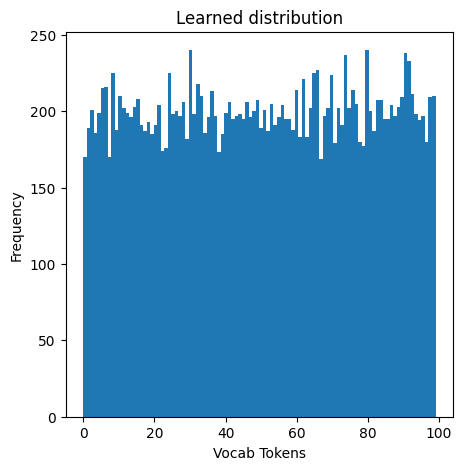

In [6]:
def main():
  vocab_size = 100
  max_len = 20
  d_model = 128
  diff = 64
  heads = 4
  layers = 2
  batch_size = 64
  epochs = 500
  evals = 1000

  model = RandomNumberTransformer(
      d_model = d_model,
      heads = heads,
      diff = diff,
      num_layers = layers,
      vocab_size = vocab_size,
      max_len = max_len
  )
  rng = jax.random.PRNGKey(42)
  rng, init_rng = jax.random.split(rng)
  state = create_train_state(
      init_rng,
      model,
      input_shape = (batch_size, max_len)
  )

  losses = []
  for i in range(epochs):
    batch = generate_random_number_sequence(batch_size, max_len, vocab_size)
    state, loss = train_step(state, batch)
    losses.append(loss)

    if i % 10 == 0:
      print(f"Epoch: {i} | Loss: {loss}")

  test_input = generate_random_number_sequence(1, max_len, vocab_size)
  generated_logits = model.apply({"params": state.params}, test_input, training = False)
  generated_logits = jax.nn.log_softmax(generated_logits, axis = -1)
  generated_sequence = jnp.argmax(generated_logits, axis = -1).reshape(max_len,)
  print(f"Generated Sequence: {generated_sequence}")

  test_input = generate_random_number_sequence(evals, max_len, vocab_size)
  generated_logits = model.apply({"params": state.params}, test_input, training = False)
  generated_logits = jax.nn.log_softmax(generated_logits, axis = -1)
  samples = jnp.argmax(generated_logits, axis = -1).reshape(evals * max_len,)
  plt.figure(figsize = (5, 5))
  plt.hist(samples, vocab_size)
  plt.title("Learned distribution")
  plt.xlabel("Vocab Tokens")
  plt.ylabel("Frequency")
  plt.show()


if __name__ == "__main__":
  main()